In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy
from collections import defaultdict

In [42]:
original_image = Image.open("resources/SCRATCH.02.tif")

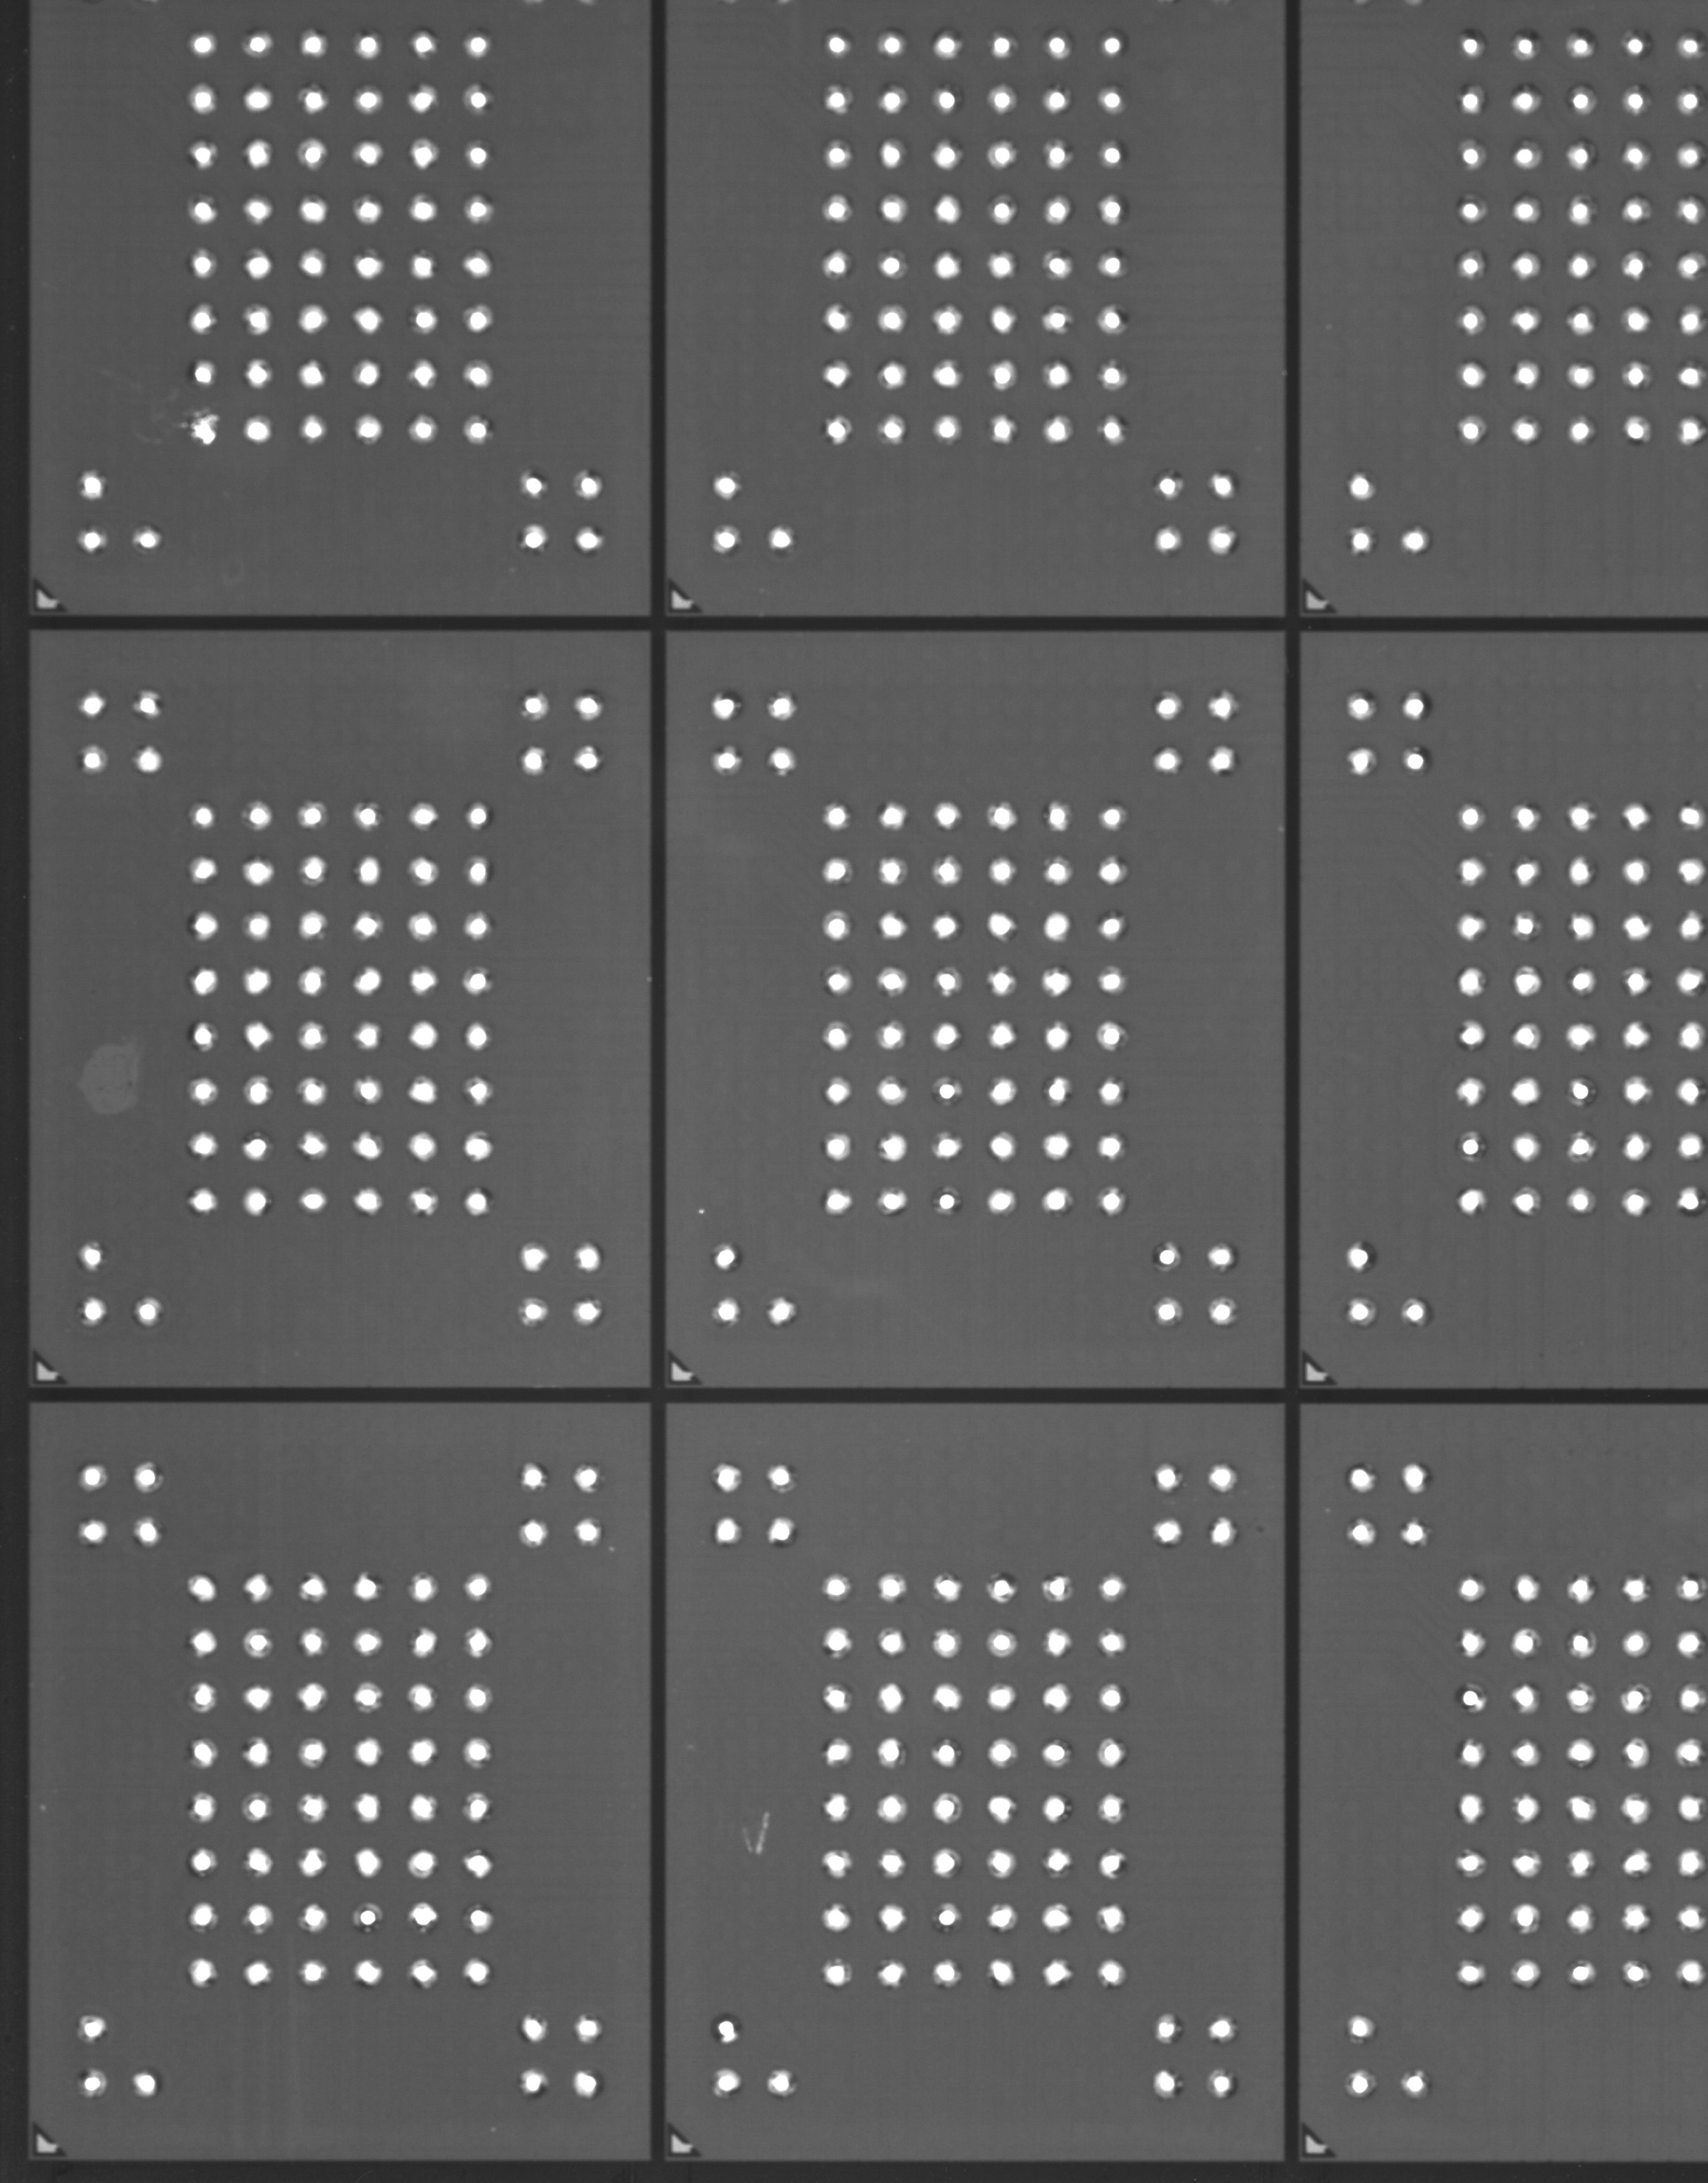

In [43]:
original_image

In [44]:
original = np.asarray(original_image)

original = (original - np.min(original))//(np.max(original) - np.min(original))

original = scipy.signal.medfilt(original, 5)

W = original.shape[1]
H = original.shape[0]

Text(0.5, 1.0, 'Original Image')

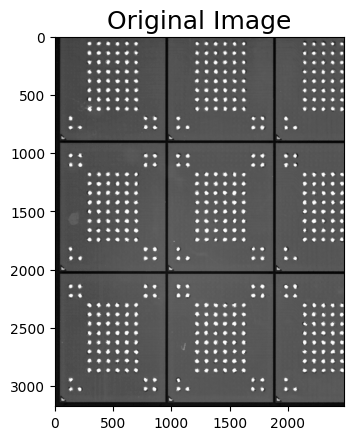

In [45]:
plt.imshow(np.asarray(original_image), cmap="Greys_r")
plt.title("Original Image", fontsize=18)

float32 0.0 255.0


Text(0.5, 1.0, 'Border filtering - I')

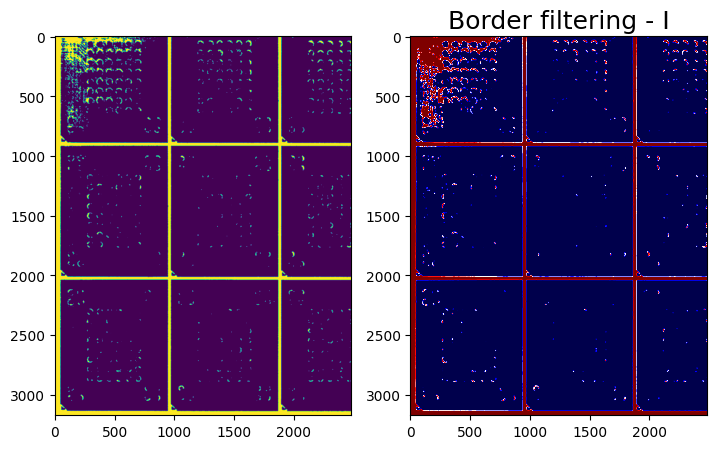

In [46]:
original = np.array(original_image).astype(np.float32)
original = scipy.signal.medfilt(original, 5)

print(original.dtype, np.min(original), np.max(original))
original = (original - np.min(original))/(np.max(original) - np.min(original))

plt.figure(figsize = (13,5))

plt.subplot(1, 3, 1)
# d = 10
plt.imshow(original < np.percentile(original.reshape(-1), 10))

n = 1
tmp = original.copy()
for i in range(n):
    original = gaussian_filter(original, sigma=7, radius=5)

plt.subplot(1, 3, 2)
plt.imshow(original < np.percentile(original.reshape(-1), 10), cmap="seismic")

plt.title("Border filtering - I", fontsize=18)

In [47]:
filter_mag = np.percentile(original.reshape(-1), 5)

In [48]:
cond = np.vectorize(lambda x: 1 if x <= filter_mag else 0)

top_masked = cond(original)

# top_masked = original

Text(0.5, 1.0, 'Border filtering - II')

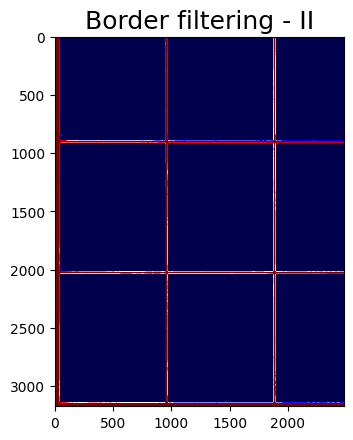

In [49]:
plt.imshow(top_masked, cmap="seismic")
plt.title("Border filtering - II", fontsize=18)

Text(0.5, 1.0, 'DFFT - filtered')

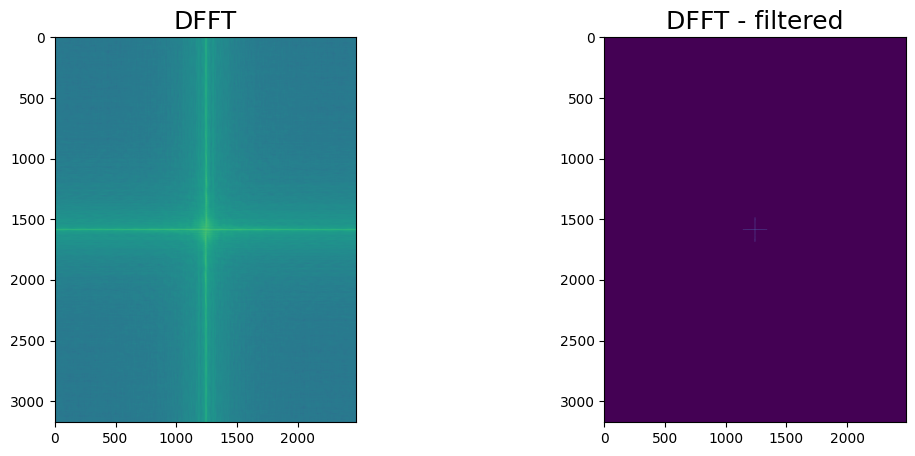

In [50]:
trans = np.fft.fft2(top_masked)

fft_img = np.fft.fftshift(trans)
req_freq = fft_img.copy()

# req_freq = np.log(np.abs(fft_img)) > 9.0
# req_freq = req_freq * fft_img
H = len(req_freq)
W = len(req_freq[0])
for i in range(H):
    for j in range(W):
        if not (np.abs(i - H//2) < 100 and np.abs(j - W//2) < 100):
            req_freq[i][j] = 0
        # if np.sqrt(np.square(i-H//2) + np.square(j-W//2)) > 300:
        #     req_freq[i][j] = 0
        # if np.sqrt(np.square(i-H//2) + np.square(j-W//2)) < 50:
        #     req_freq[i][j] = 0

# req_freq = req_freq*(np.log(np.abs(fft_img)) > 9)
req_freq = req_freq*(np.log(np.abs(fft_img)) > np.percentile(np.log(np.abs(fft_img)), 99.98))

plt.figure(figsize = (13,5 ))

plt.subplot(1, 2, 1)
plt.imshow(np.log(np.abs(fft_img)))
plt.title("DFFT", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(np.log(np.abs(req_freq)+0.000001))
plt.title("DFFT - filtered", fontsize=18)

# plt.colorbar()

In [51]:
# arr = np.log(np.abs(fft_img.reshape(-1)))
# plt.hist(arr, bins=10000)

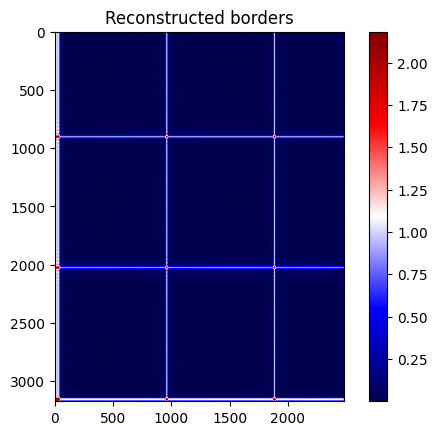

In [52]:
freq_filt_img = np.fft.ifft2(np.fft.ifftshift(req_freq))

freq_filt_img = np.abs(freq_filt_img)
freq_filt_img = freq_filt_img.astype(np.float32)

plt.imshow(freq_filt_img, cmap="seismic")
plt.title("Reconstructed borders")

plt.colorbar()

Text(0.5, 1.0, 'Extracted intersection points')

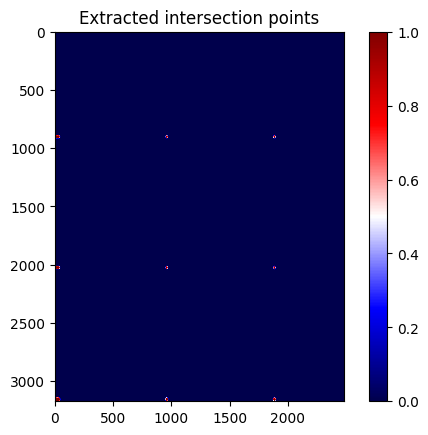

In [53]:
# plt.imshow(freq_filt_img > 1.3)
plt.imshow(freq_filt_img > 1.3, cmap="seismic")
plt.colorbar()
plt.title("Extracted intersection points")

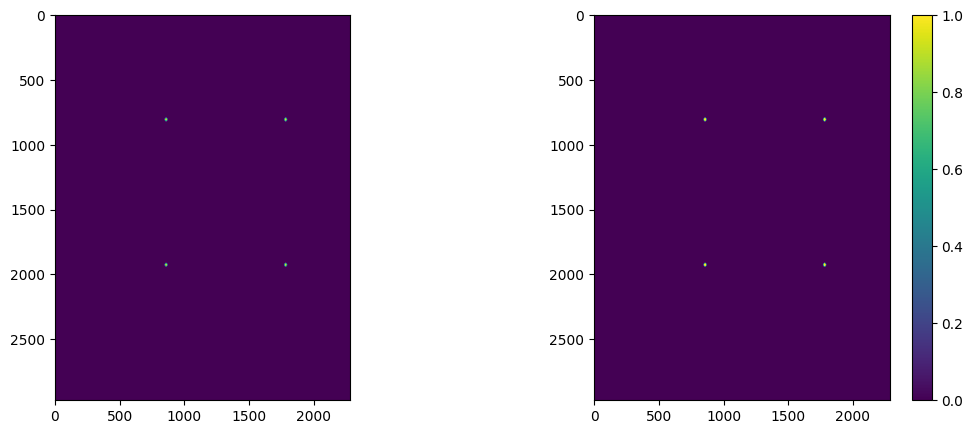

In [54]:
freq_filt_img_smo = gaussian_filter(freq_filt_img * (freq_filt_img > 1.5), sigma=2)
freq_filt_img_smo = freq_filt_img[100:-100,100:-100]*(freq_filt_img[100:-100,100:-100] > 1.2)
# freq_filt_img_smo = freq_filt_img*(freq_filt_img > 1.2)

plt.figure(figsize = (13,5 ))
plt.subplot(1, 2, 1)
plt.imshow(freq_filt_img_smo)

plt.subplot(1, 2, 2)
plt.imshow(freq_filt_img_smo > 1)

plt.colorbar()

In [55]:
positions = defaultdict(list)

points = freq_filt_img_smo > 1
result = []

def dist(x, y):
    return np.sqrt(np.sum(np.square(x-y)))

dots = np.argwhere(points)
for dot in dots:
    found = False
    for k, v in positions.items():
        if dist(np.array(k), dot) < 90:
            positions[k].append(dot)
            found = True
    
    if not found:
        positions[(dot[0], dot[1])].append(dot)

for xpos, yposes in positions.items():
    yposes = np.array(yposes)
    result.append((np.mean(yposes[:,0]), np.mean(yposes[:,1])))

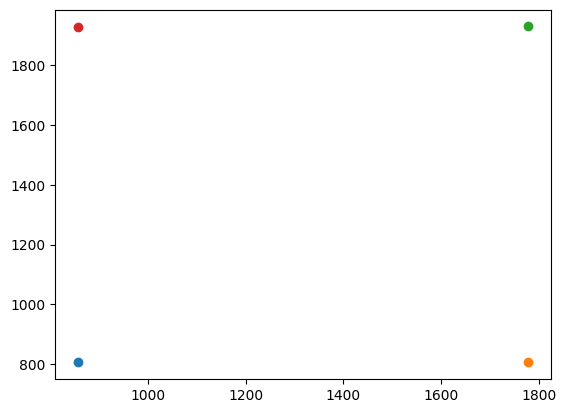

In [56]:
for point in result:
    plt.scatter([point[1]], [point[0]])

In [57]:
result = [[int(x[0]), int(x[1])] for x in result]

In [58]:
l1 = 100000
l2 = 100000

for d1 in result:
    cxdistances = []
    cydistances = []
    for d2 in result:
        if np.abs(d1[1]-d2[1]) < 30:
            cxdistances.append(np.abs(d1[0]-d2[0]))
        if np.abs(d1[0]-d2[0]) < 30:
            cydistances.append(np.abs(d1[1]-d2[1]))
    cxdistances.sort()
    cydistances.sort()
    cxdistances = cxdistances[1:]
    cydistances = cydistances[1:]

    # print(cdistances, l1, l2)
    print(cxdistances, cydistances)
    if len(cxdistances) > 0 and cxdistances[0] < l1:
        l1 = cxdistances[0]

    if len(cydistances) > 0 and cydistances[0] < l2:
        l2 = cydistances[0]

[1122] [922]
[1122] [922]
[1122] [922]
[1122] [922]


In [59]:
result = np.array(result)
print(result)
print(points)

[[ 806  856]
 [ 806 1778]
 [1928 1778]
 [1928  856]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [61]:
points = result.copy()
curr_point = result[0]

x = curr_point[1]
y = curr_point[0]

def is_near(a, b):
    return np.sum(np.square(a - b)) < 2500
def exist(arr, val):
    rez = np.min(np.sum(np.square(arr - val), axis=1))
    return rez < 2500

d = 100
cy = y
while cy+d >= 0:
    cx = x
    while cx+d >= 0:
        if not exist(points, np.array([cy, cx])):
            points = np.append(points, [[cy, cx]], axis=0)
        cx -= l2
    cx = x
    while cx-d <= W:
        if not exist(points, np.array([cy, cx])):
            points = np.append(points, [[cy, cx]], axis=0)
        cx += l2
    cy -= l1

cy = y
while cy-d <= H:
    cx = x
    while cx+d >= 0:
        if not exist(points, np.array([cy, cx])):
            points = np.append(points, [[cy, cx]], axis=0)
        cx -= l2
    cx = x
    while cx-d <= W:
        if not exist(points, np.array([cy, cx])):
            points = np.append(points, [[cy, cx]], axis=0)
        cx += l2
    cy += l1

points = np.array(points)

In [62]:
points

array([[ 806,  856],
       [ 806, 1778],
       [1928, 1778],
       [1928,  856],
       [ 806,  -66],
       [1928,  -66],
       [3050,  856],
       [3050,  -66],
       [3050, 1778]])

Text(0.5, 1.0, 'Intersection points')

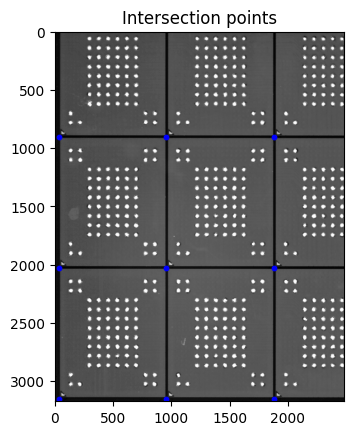

In [63]:
plt.imshow(np.asarray(original_image), cmap="Greys_r")
# for point in result:
    # plt.scatter([point[1]], [point[0]], s=10, c="r")
plt.scatter(100+points[:,1], 100+points[:,0], s=10, c="b")
# plt.scatter(100+x, 100+y, s=10, c="r")
plt.title("Intersection points")

In [64]:
points = np.array([x for x in points if x[0] < H-100 and x[1] < W])

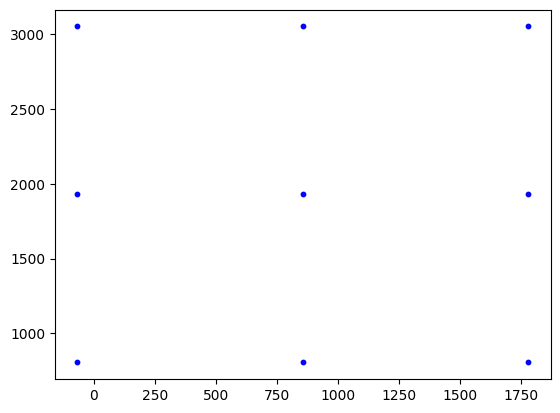

In [65]:
plt.scatter(points[:,1], points[:,0], s=10, c="b")
# plt.scatter(pp[:,1], pp[:,0], s=10, c="r")

In [66]:
squares = []

for point in points:
    if exist(points, np.array([point[0]+l1, point[1]])) and \
        exist(points, np.array([point[0]+l1, point[1]+l2])) and \
        exist(points, np.array([point[0], point[1]+l2])):
        squares.append([x for x in points if is_near(x, point) or is_near(x, np.array([point[0]+l1, point[1]])) or is_near(x, np.array([point[0]+l1, point[1]+l2])) or is_near(x, np.array([point[0], point[1]+l2]))])
    
squares = np.array(squares)

for i in range(len(squares)):
    row = squares[i]
    squares[i] = np.array([
        [row[:,0].min(), row[:,1].min()],
        [row[:,0].max(), row[:,1].min()],
        [row[:,0].max(), row[:,1].max()],
        [row[:,0].min(), row[:,1].max()],
    ])

Text(0.5, 1.0, 'Bounding rectangles')

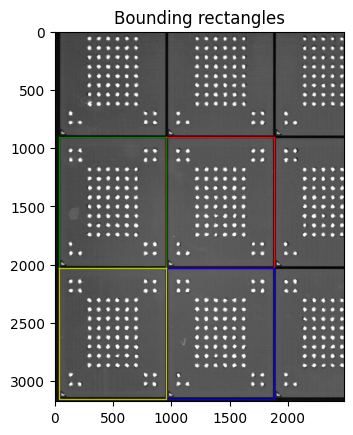

In [67]:
colors = ["r", "b", "g", "y", "pink"]*100

plt.imshow(np.asarray(original_image), cmap="Greys_r")
for i, _ in enumerate(squares):
    # rect = np.sort(squares[i].copy(), axis=0)
    rect = squares[i].copy()
    rect = rect[rect[:,1].argsort()]
    plt.plot(100+rect[:,1], 100+rect[:,0], c=colors[i], linewidth=1)
    plt.plot([100+rect[0,1], 100+rect[-1,1]], [100+rect[0,0], 100+rect[-1,0]], c=colors[i], linewidth=1)

plt.title("Bounding rectangles")